# Image Formation, Sampling, Filtering, Edges & Geometric Transformations

In [1]:
!pip install opencv-python scikit-image --quiet

import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import data, color

%matplotlib inline

plt.rcParams['figure.figsize'] = (6, 6)
plt.rcParams['image.cmap'] = 'gray'

def show(img, title="Image", cmap='gray'):
    plt.figure()
    plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.show()

## Task 1 – Image Formation & Sampling

### 1.1 Load a real-life image and convert to grayscale

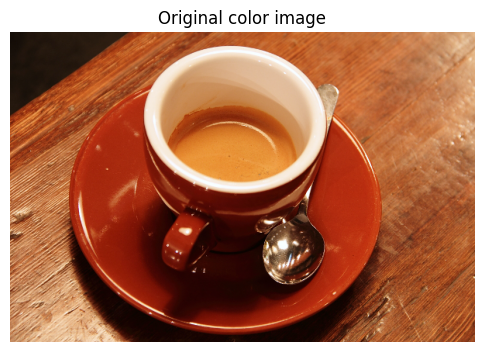

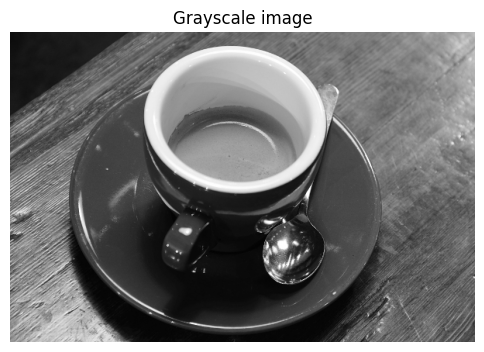

In [2]:
# Use the real-life coffee photo (color)
img_color = data.coffee()
show(img_color, "Original color image", cmap=None)

# Convert to grayscale for all further processing
img = color.rgb2gray(img_color)
img = img.astype(np.float32)  # already in [0,1]

show(img, "Grayscale image")

### 1.2 Naive downsampling (no prefiltering)



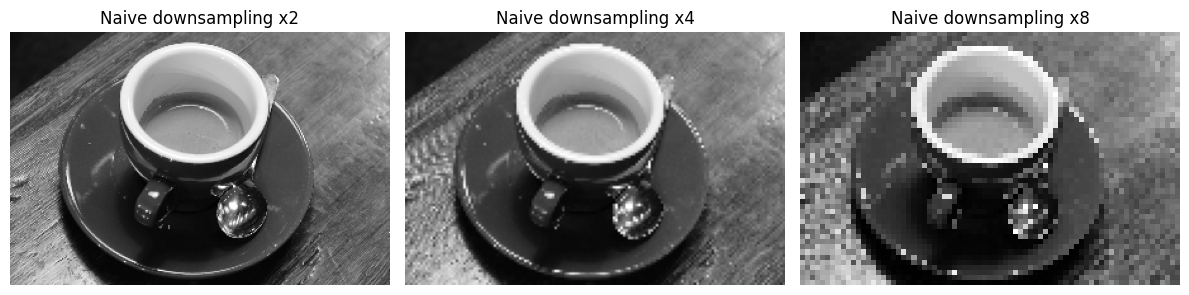

In [3]:
def downsample_naive(image, factor):
    """Downsample by taking every `factor`-th pixel."""
    return image[::factor, ::factor]

factors = [2, 4, 8]
down_naive = {f: downsample_naive(img, f) for f in factors}

plt.figure(figsize=(12,4))
for i, f in enumerate(factors, 1):
    plt.subplot(1, 3, i)
    plt.imshow(down_naive[f], cmap='gray')
    plt.title(f"Naive downsampling x{f}")
    plt.axis('off')
plt.tight_layout()
plt.show()

### 1.3 Downsampling with Gaussian prefiltering (anti-aliasing)

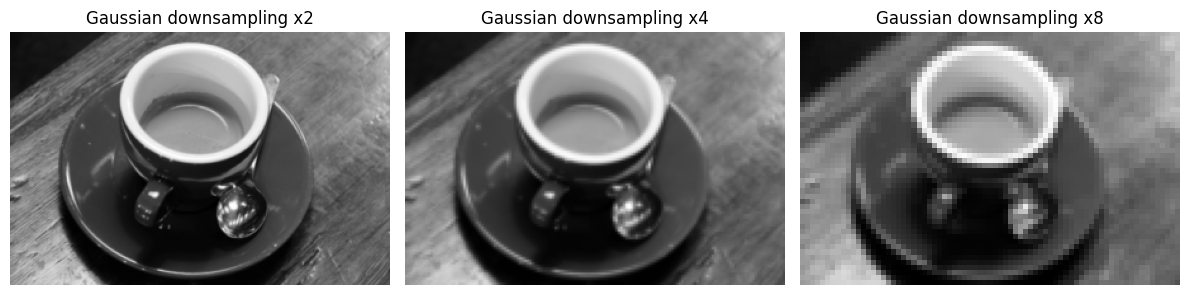

In [22]:
def downsample_with_prefilter(image, factor, sigma=None):
    """Gaussian blur then subsample. sigma ~= factor/2 is a reasonable choice."""
    if sigma is None:
        sigma = factor / 2.0
    blurred = cv2.GaussianBlur(image, (0, 0), sigmaX=sigma, sigmaY=sigma)
    return blurred[::factor, ::factor]

down_blur = {f: downsample_with_prefilter(img, f, sigma=f/2.0) for f in factors}

plt.figure(figsize=(12,4))
for i, f in enumerate(factors, 1):
    plt.subplot(1, 3, i)
    plt.imshow(down_blur[f], cmap='gray')
    plt.title(f"Gaussian downsampling x{f}")
    plt.axis('off')
plt.tight_layout()
plt.show()

### 1.4 Frequency spectra (2D Fourier Transform)

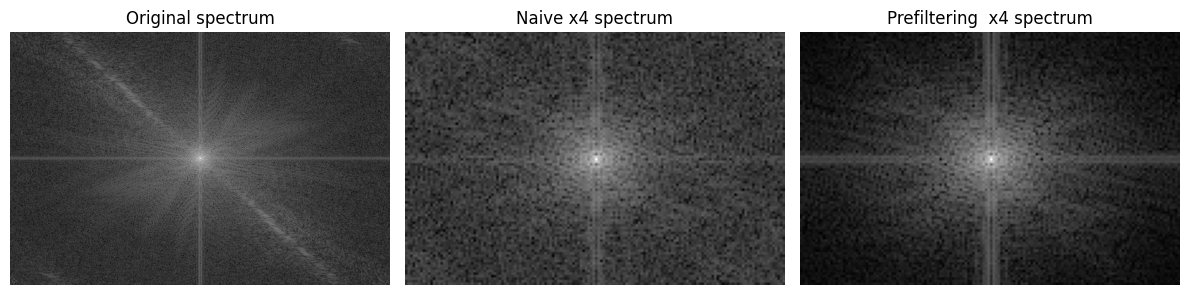

In [23]:
def show_spectrum(image, title="Spectrum"):
    F = np.fft.fft2(image)
    F_shift = np.fft.fftshift(F)
    magnitude = np.log1p(np.abs(F_shift))
    plt.imshow(magnitude, cmap='gray')
    plt.title(title)
    plt.axis('off')

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); show_spectrum(img, "Original spectrum")
plt.subplot(1,3,2); show_spectrum(down_naive[4], "Naive x4 spectrum")
plt.subplot(1,3,3); show_spectrum(down_blur[4], "Prefiltering  x4 spectrum")
plt.tight_layout()
plt.show()

## Task 2 – Linear Filters & Convolution


### 2.1 Implement 2D convolution (with zero padding)

In [6]:
def convolve2d(image, kernel):
    """Simple 2D convolution with zero-padding, using nested loops."""
    kh, kw = kernel.shape
    pad_h, pad_w = kh // 2, kw // 2

    padded = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant')
    out = np.zeros_like(image, dtype=np.float32)

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            region = padded[i:i+kh, j:j+kw]
            out[i, j] = np.sum(region * kernel)
    return out

### 2.2 Box filters (3×3 and 5×5)

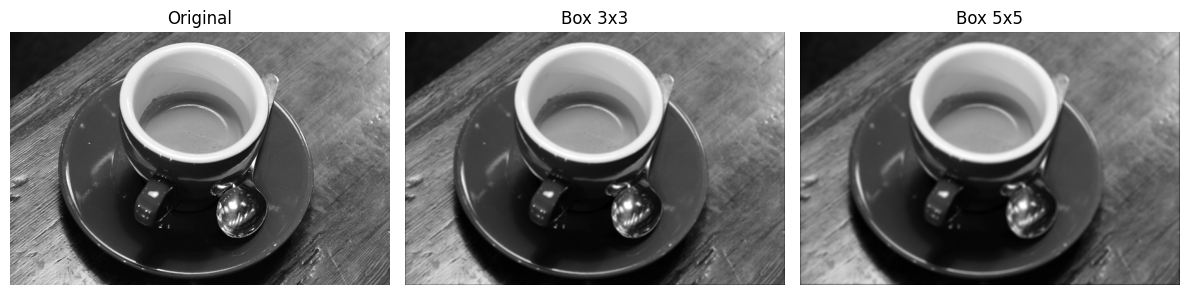

In [7]:
box3 = np.ones((3,3), dtype=np.float32) / 9.0
box5 = np.ones((5,5), dtype=np.float32) / 25.0

img_box3 = convolve2d(img, box3)
img_box5 = convolve2d(img, box5)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(img, cmap='gray'); plt.title("Original"); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(img_box3, cmap='gray'); plt.title("Box 3x3"); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(img_box5, cmap='gray'); plt.title("Box 5x5"); plt.axis('off')
plt.tight_layout()
plt.show()

### 2.3 Gaussian filters (σ = 1, 2)


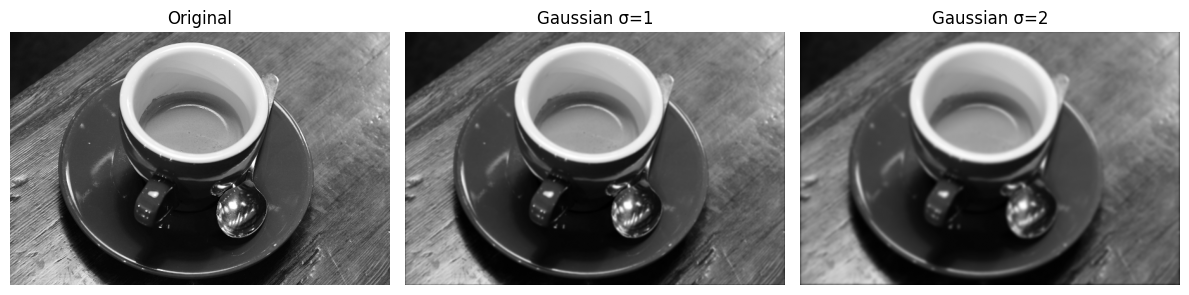

In [8]:
def gaussian_kernel(size, sigma):
    ax = np.arange(-size//2 + 1., size//2 + 1.)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2. * sigma**2))
    kernel /= np.sum(kernel)
    return kernel.astype(np.float32)

g1 = gaussian_kernel(5, sigma=1)
g2 = gaussian_kernel(9, sigma=2)

img_g1 = convolve2d(img, g1)
img_g2 = convolve2d(img, g2)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(img, cmap='gray'); plt.title("Original"); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(img_g1, cmap='gray'); plt.title("Gaussian σ=1"); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(img_g2, cmap='gray'); plt.title("Gaussian σ=2"); plt.axis('off')
plt.tight_layout()
plt.show()

### 2.4 Compare manual convolution with OpenCV implementations

In [9]:
# Box filters (OpenCV)
cv_box3 = cv2.blur(img, (3,3))
cv_box5 = cv2.blur(img, (5,5))

# Gaussian filters (OpenCV)
cv_g1 = cv2.GaussianBlur(img, (5,5), 1)
cv_g2 = cv2.GaussianBlur(img, (9,9), 2)

print("Max abs difference - Box 3x3:", np.abs(img_box3 - cv_box3).max())
print("Max abs difference - Box 5x5:", np.abs(img_box5 - cv_box5).max())
print("Max abs difference - Gauss σ=1:", np.abs(img_g1 - cv_g1).max())
print("Max abs difference - Gauss σ=2:", np.abs(img_g2 - cv_g2).max())

Max abs difference - Box 3x3: 0.41634345
Max abs difference - Box 5x5: 0.47618926
Max abs difference - Gauss σ=1: 0.37975356
Max abs difference - Gauss σ=2: 0.47243822


### Bonus – Demonstrate convolution commutativity numerically

Here we show that convolving an image with kernel A then kernel B gives (almost) the same result as convolving with B then A, i.e. `A * (B * image) ≈ B * (A * image)`. Small differences only come from numerical rounding.

Max abs difference between (A then B) and (B then A): 0.076898456


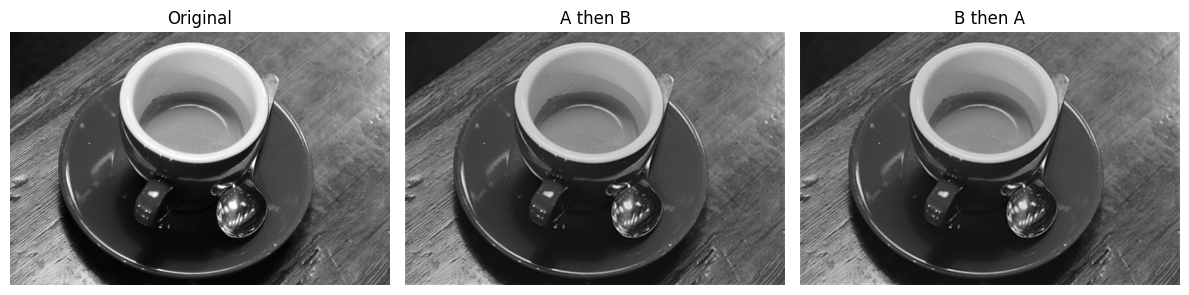

In [10]:
# Define two different kernels
kA = gaussian_kernel(5, sigma=1)         # Gaussian blur
kB = np.array([[0, -1, 0],               # Simple sharpening-like kernel
               [-1, 5, -1],
               [0, -1, 0]], dtype=np.float32)

# Convolve image with A then B
img_A_then_B = convolve2d(convolve2d(img, kA), kB)

# Convolve image with B then A
img_B_then_A = convolve2d(convolve2d(img, kB), kA)

# Compute maximum absolute difference
max_diff = np.abs(img_A_then_B - img_B_then_A).max()
print("Max abs difference between (A then B) and (B then A):", max_diff)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(img, cmap='gray'); plt.title("Original"); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(img_A_then_B, cmap='gray'); plt.title("A then B"); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(img_B_then_A, cmap='gray'); plt.title("B then A"); plt.axis('off')
plt.tight_layout()
plt.show()

**Observation (for your report):**

- The two resulting images look visually identical.
- The printed maximum absolute difference should be very small (close to numerical precision, e.g. ~1e-5).
- This empirically demonstrates the **commutativity of convolution**: `kA * (kB * image) ≈ kB * (kA * image)`.

## Task 3 – Edge Detection (Sobel & Prewitt)

We will:
1. Define Sobel and Prewitt kernels.
2. Compute horizontal (Gx) and vertical (Gy) gradients via convolution.
3. Compute gradient magnitude and orientation.
4. Compare with OpenCV’s Sobel implementation.
5. Explain gradient direction vs edge orientation.

### 3.1 Sobel and Prewitt kernels

In [11]:
# Sobel kernels
sobel_x = np.array([[-1, 0, 1],
                    [-2, 0, 2],
                    [-1, 0, 1]], dtype=np.float32)

sobel_y = np.array([[-1, -2, -1],
                    [ 0,  0,  0],
                    [ 1,  2,  1]], dtype=np.float32)

# Prewitt kernels
prewitt_x = np.array([[-1, 0, 1],
                      [-1, 0, 1],
                      [-1, 0, 1]], dtype=np.float32)

prewitt_y = np.array([[-1, -1, -1],
                      [ 0,  0,  0],
                      [ 1,  1,  1]], dtype=np.float32)

### 3.2 Sobel gradients: Gx, Gy, magnitude, orientation

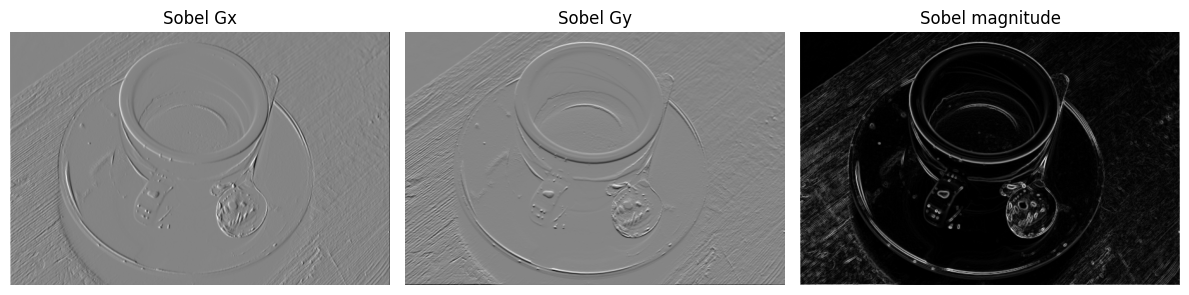

In [12]:
gx_s = convolve2d(img, sobel_x)
gy_s = convolve2d(img, sobel_y)

mag_s = np.sqrt(gx_s**2 + gy_s**2)
ori_s = np.arctan2(gy_s, gx_s)  # radians, range [-pi, pi]

mag_s_disp = mag_s / (mag_s.max() + 1e-8)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(gx_s, cmap='gray'); plt.title("Sobel Gx"); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(gy_s, cmap='gray'); plt.title("Sobel Gy"); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(mag_s_disp, cmap='gray'); plt.title("Sobel magnitude"); plt.axis('off')
plt.tight_layout()
plt.show()

### 3.3 Prewitt gradients and magnitude

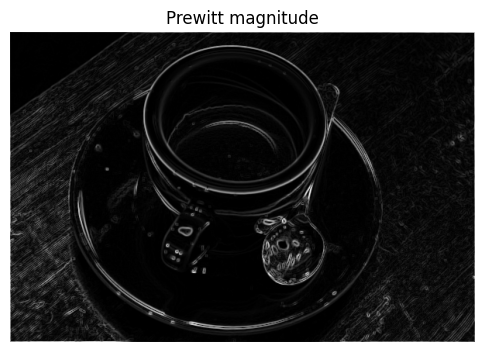

In [13]:
gx_p = convolve2d(img, prewitt_x)
gy_p = convolve2d(img, prewitt_y)

mag_p = np.sqrt(gx_p**2 + gy_p**2)
mag_p_disp = mag_p / (mag_p.max() + 1e-8)

show(mag_p_disp, "Prewitt magnitude")

### 3.4 Compare with OpenCV Sobel

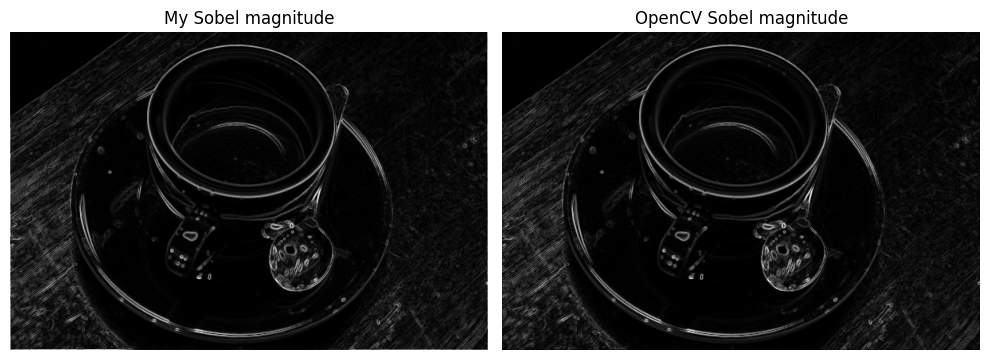

In [14]:
sobelx_cv = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=3)
sobely_cv = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=3)
mag_cv = np.sqrt(sobelx_cv**2 + sobely_cv**2)
mag_cv_disp = mag_cv / (mag_cv.max() + 1e-8)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.imshow(mag_s_disp, cmap='gray'); plt.title("My Sobel magnitude"); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(mag_cv_disp, cmap='gray'); plt.title("OpenCV Sobel magnitude"); plt.axis('off')
plt.tight_layout()
plt.show()

### 3.6 (Optional) Canny edge detector

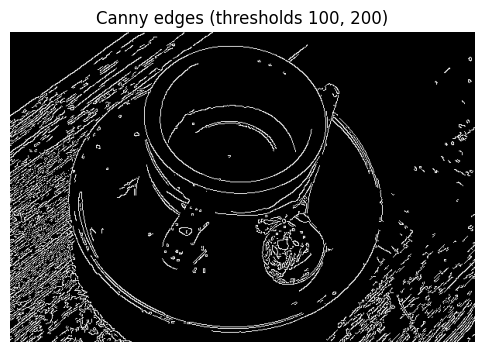

In [15]:
edges_canny = cv2.Canny((img*255).astype(np.uint8), 100, 200)
show(edges_canny, "Canny edges (thresholds 100, 200)")

## Task 4 – Geometric Transformations


### 4.1 Image shape

In [16]:
h, w = img.shape
print("Image size (h, w):", h, w)

Image size (h, w): 400 600


### 4.2 Translation


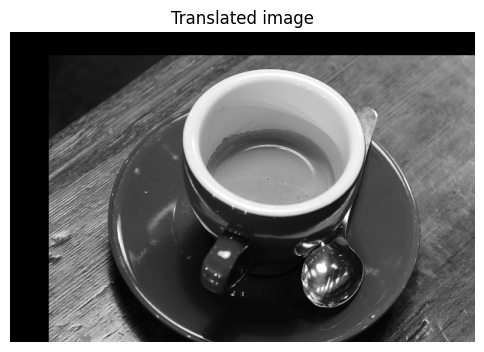

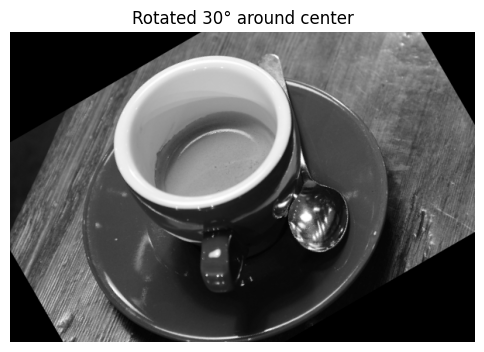

In [26]:
tx, ty = 50, 30  # shift right by 50, down by 30
M_trans = np.float32([[1, 0, tx],
                      [0, 1, ty]])

img_trans = cv2.warpAffine(img, M_trans, (w, h))
show(img_trans, "Translated image")
show(img_rot, "Rotated 30° around center")


### 4.3 Rotation (around image center)


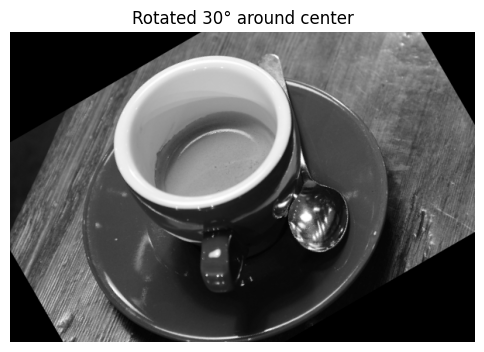

In [18]:
center = (w/2, h/2)
angle = 30  # degrees
scale = 1.0

M_rot = cv2.getRotationMatrix2D(center, angle, scale)
img_rot = cv2.warpAffine(img, M_rot, (w, h))
show(img_rot, "Rotated 30° around center")

### 4.4 Scaling


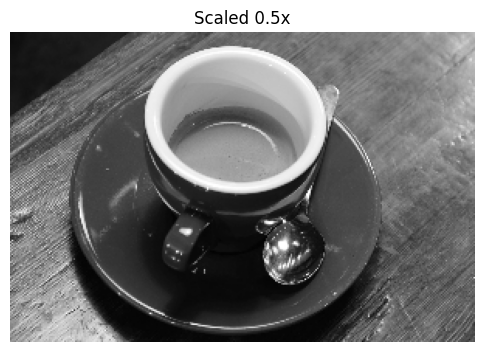

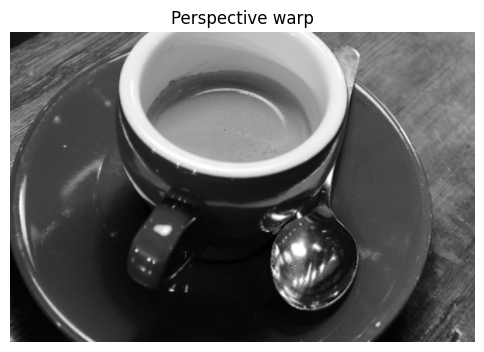

In [27]:
sx, sy = 0.5, 0.5  # half size
M_scale = np.float32([[sx, 0, 0],
                      [0, sy, 0]])

img_scaled = cv2.warpAffine(img, M_scale, (int(w*sx), int(h*sy)))
show(img_scaled, "Scaled 0.5x")
show(img_persp, "Perspective warp")

### 4.5 Perspective transform (homography)


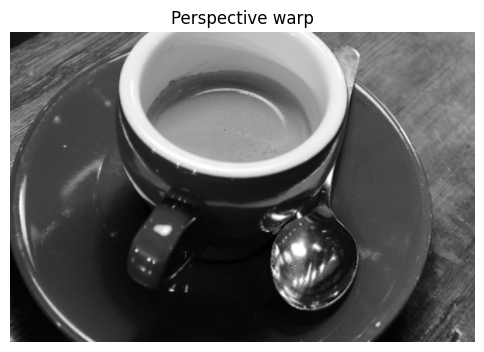

In [20]:
# Define four points in the source image (roughly a quadrilateral)
src_pts = np.float32([
    [50, 50],
    [w - 50, 50],
    [w - 100, h - 50],
    [100, h - 50]
])

# Map them to the corners of the full output image
dst_pts = np.float32([
    [0, 0],
    [w - 1, 0],
    [w - 1, h - 1],
    [0, h - 1]
])

H = cv2.getPerspectiveTransform(src_pts, dst_pts)
img_persp = cv2.warpPerspective(img, H, (w, h))
show(img_persp, "Perspective warp")